<a href="https://colab.research.google.com/github/daisy-dotcom/ms_pacman/blob/main/ms_pacman_ppo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# run this cell once per Colab session
!apt update
!apt-get install xvfb x11-utils
!python -m pip install --upgrade swig
!python -m pip install --upgrade pyvirtualdisplay moviepy
!python -m pip install --upgrade gymnasium[accept-rom-license,atari,box2d,classic_control,mujoco,toy_text]
!python -m pip install torchinfo

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,031 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Ign:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,159 kB]
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3,200 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages

In [ ]:
# import necessary libraries
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from collections import deque
from pyvirtualdisplay import Display
import moviepy.editor as mpy
from torchinfo import summary
from tqdm.notebook import tqdm
import random
import ale_py

gym.register_envs(ale_py)
# create and start virtual display
display = Display(backend='xvfb')
display.start()

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
  torch.set_default_device(torch.device(device))

torch.cuda.is_available()

True

In [ ]:
torch.get_default_device()

device(type='cuda', index=0)

In [ ]:
device = torch.get_default_device()

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
seed = 2023
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
seed=None

In [ ]:
class Storage(Dataset):
    def __init__(self, rollout, advantages, returns, envs):
        # fill in the storage and flatten the parallel trajectories
        self.observations = rollout['obs'].reshape((-1,) +  envs.single_observation_space.shape)
        self.logprobs = rollout['logprobs'].reshape(-1)
        self.actions = rollout['actions'].reshape((-1,) +  envs.single_action_space.shape).long()
        self.advantages = advantages.reshape(-1)
        self.returns = returns.reshape(-1)

    def __getitem__(self, ix: int):
        item = [
            self.observations[ix],
            self.logprobs[ix],
            self.actions[ix],
            self.advantages[ix],
            self.returns[ix]
        ]
        return item

    def __len__(self) -> int:
        return len(self.observations)

In [ ]:
# Actor-critic network for approximating the policy & advantage function
class PPONetwork(nn.Module):
    def __init__(self,
                 in_channels,
                 hidden_sizes,
                 output_size,
                 learning_rate):
        super().__init__()
        # create network layers
        actor_layers = nn.ModuleList()
        critic_layers = nn.ModuleList()
        # input layers
        layer = self.init_weights((nn.Linear(in_channels, hidden_sizes[0])))
        actor_layers.append(layer)
        critic_layers.append(layer)

        actor_layers.append(nn.Tanh())
        critic_layers.append(nn.Tanh())

        # hidden layers
        for i in range(len(hidden_sizes)-1):
            layer = self.init_weights(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            activation = nn.Tanh()
            actor_layers.append(layer)
            actor_layers.append(activation)
            critic_layers.append(layer)
            critic_layers.append(activation)

        # output layers
        # outputs a 1D tensor of size 1 with the Q value
        #layers.append(nn.Linear(hidden_sizes[-1], output_size))
        # combine layers into feed-forward network

        actor_layers.append(self.init_weights(nn.Linear(hidden_sizes[-1], output_size)))
        critic_layers.append(self.init_weights(nn.Linear(hidden_sizes[-1], 1), std=1.0))

        self.actor_net = nn.Sequential(*actor_layers)
        self.critic_net = nn.Sequential(*critic_layers)

        # select loss function and optimizer
        # note: original paper uses modified MSE loss and RMSprop
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=learning_rate)

        # initialise the weights according to dueling network architecture
        #self.apply(self.init_weights)
        if torch.cuda.is_available():
          self.device = torch.device('cuda:0')
        else:
          self.device = torch.device('cpu')

        self.to(self.device)

    def init_weights(self, layer, std=np.sqrt(2), bias_const=0):
        torch.nn.init.orthogonal_(layer.weight, std)
        torch.nn.init.constant_(layer.bias, bias_const)
        return layer

    def forward(self, x):
        # convert input to torch format
        return self.net(x)

    def get_action_and_value(self, state, action=None):
        if not torch.is_tensor(state):
            state = torch.tensor(state, dtype=torch.float)
        state = state.to(self.device)
        logits = self.actor_net(state)
        probs = torch.distributions.Categorical(logits=logits)

        if action is None:
            action = probs.sample()

        return action, probs.log_prob(action), probs.entropy(), self.critic_net(state)

    def get_value(self, state):
        if not torch.is_tensor(state):
            state = torch.tensor(state, dtype=torch.float)
        state = state.to(self.device)
        # convert input to torch format
        return self.critic_net(state)

    def update(self, state, action, targets):
        # update network weights for a minibatch of inputs and targets:
        self.optimizer.zero_grad()
        outputs = self.forward(state)
        #print(outputs.shape)
        #print(targets.shape)
        outputs = outputs.gather(1, action.long())
        loss = self.criterion(outputs, targets)
        loss.backward()
        self.optimizer.step()

    def copy_from(self, qnetwork):
        # copy weights from another Q-network
        self.net.load_state_dict(qnetwork.net.state_dict())

In [ ]:
def make_env(name, seed=None):
    env = gym.make(name, render_mode='rgb_array_list')
    env = gym.wrappers.RecordEpisodeStatistics(env)
    if seed is not None:
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
    return env

In [ ]:
from os import stat_result
# source: https://colab.research.google.com/drive/1AmdtDNd_DUVRJlluaKIGT19BzBZ7loVZ?usp=sharing&authuser=1#scrollTo=56b3d5ca

class PPOAgent():
    def __init__(self,
                 env_name='CartPole-v1',
                 n_envs=2,
                 gamma=0.99,
                 hidden_sizes=(32, 32),
                 learning_rate=0.001,
                 num_minibatch=2,
                 minibatch_size=32,
                 max_steps=200,
                 lam=0.95,
                 update_epochs=4,
                 clip_epsilon=0.2,
                 ent_coef=0.01,
                 vf_coef=0.5,
                 max_grad_norm=0.5,
                 target_kl=None,
                 num_returns_to_avg=3,
                 num_episodes_to_avg=23,
                 total_timesteps=100000):

        self.n_envs = n_envs
        self.env_name = env_name
        self.envs = gym.vector.SyncVectorEnv([lambda: make_env(env_name, seed) for _ in range(self.n_envs)])

        # check if the state space has correct type
        #continuous = isinstance(env.observation_space, spaces.Box) and len(env.observation_space.shape) == 1
        #assert continuous, 'Observation space must be continuous with shape (n,)'
        self.state_dims = self.envs.single_observation_space.shape[0]
        #self.state_dims = env.observation_space.n

        # check if the action space has correct type
        assert isinstance(self.envs.action_space, spaces.MultiDiscrete), 'Action space must be discrete'
        self.num_actions = self.envs.single_action_space.n

        # create actor & critic network
        self.agent = PPONetwork(self.state_dims, hidden_sizes, self.num_actions, learning_rate)

        self.lr = learning_rate
        self.num_minibatch = num_minibatch
        self.minibatch_size = minibatch_size
        self.max_steps = max_steps
        self.gamma = gamma
        self.lam = lam
        self.update_epochs = update_epochs
        self.clip_epsilon = clip_epsilon
        self.ent_coef = ent_coef
        self.vf_coef = vf_coef
        self.max_grad_norm = max_grad_norm
        self.num_returns_to_avg = num_returns_to_avg
        self.num_episodes_to_avg = num_episodes_to_avg
        self.total_timesteps = total_timesteps
        self.target_kl = target_kl
        self.batch_size = n_envs * max_steps

    def policy(self, state, stochastic=True):
        # convert state to torch format
        if not torch.is_tensor(state):
            state = torch.tensor(state, dtype=torch.float)

        # calculate action probabilities
        with torch.no_grad():
          action, _ , _ , _ = self.agent.get_action_and_value(state).detach()
        return action

    def generalised_advantage_estimation(self, cur_obs, rewards, dones, values):
      advantages = torch.zeros((self.n_envs, self.max_steps))
      last_advantage = 0

      # the value after the last step
      with torch.no_grad():
          last_value = self.agent.get_value(cur_obs).reshape(1, -1)

      # reverse recursive to calculate advantages based on the delta formula
      for t in reversed(range(self.max_steps)):
          # mask if episode completed after step t
          mask = 1.0 - dones[:, t]
          last_value = last_value * mask
          last_advantage = last_advantage * mask
          delta = rewards[:, t] + self.gamma * last_value - values[:, t]
          last_advantage = delta + self.gamma * self.lam * last_advantage
          advantages[:, t] = last_advantage
          last_value = values[:, t]

      advantages = advantages
      returns = advantages + values

      return advantages, returns

    # starting obs, current termination status, track all returns
    def create_rollout(self, cur_observation, cur_done):
      """
      create trajectories from all environments and store them
      """
      # empty tensors to store the rollouts
      observations = torch.zeros((self.n_envs, self.max_steps ) + self.envs.single_observation_space.shape)
      actions = torch.zeros((self.n_envs, self.max_steps) + self.envs.single_action_space.shape)
      logprobs = torch.zeros((self.n_envs, self.max_steps))
      rewards = torch.zeros((self.n_envs,self.max_steps))
      dones = torch.zeros((self.n_envs, self.max_steps))
      values = torch.zeros((self.n_envs, self.max_steps))

      for t in range(self.max_steps):
          observations[:,t] = cur_observation
          dones[:,t] = cur_done

          # give observation to the model and collect action, logprobs of actions, entropy and value
          with torch.no_grad():
              action, logprob, entropy, value = self.agent.get_action_and_value(cur_observation)

          values[:,t] = value.flatten()
          actions[:,t] = action
          logprobs[:,t] = logprob

          # apply the action to the env and collect observation and reward
          cur_observation, reward, cur_done, _, info = self.envs.step(action.cpu().numpy())
          is_done = cur_done
          rewards[:,t] = torch.tensor(reward).view(-1)
          cur_observation = torch.tensor(cur_observation, dtype=torch.float32)
          cur_done = torch.tensor(cur_done)

          # if an episode ended store its total reward for progress report
          if is_done.any():
            pos = np.where(is_done == True)
            if info:
              for item in info:
                if item and "episode" in item:
                  #print(f"Reward at end: {info['episode']['r'][pos]}")
                  self.all_returns = self.all_returns + list(info['episode']['r'][pos])
                  break


      # create the rollout storage
      rollout = {
          'cur_obs': cur_observation,
          'cur_done': cur_done,
          'obs': observations,
          'actions': actions,
          'logprobs': logprobs,
          'values': values,
          'dones': dones,
          'rewards': rewards
      }

      return rollout

    def loss_clip(self, mb_oldlogporb, mb_newlogprob, mb_advantages):
      """
      mb_oldlogporb,     # old logprob of mini batch actions collected during the rollout
      mb_newlogprob,     # new logprob of mini batch actions created by the new policy
      mb_advantages      # mini batch of advantages collected during the the rollout
      policy loss with clipping to control gradients
      """
      ratio = torch.exp(mb_newlogprob - mb_oldlogporb)
      policy_loss = -mb_advantages * ratio

      with torch.no_grad():
        logratio = torch.log(ratio)
        # calculate approx_kl http://joschu.net/blog/kl-approx.html
        old_approx_kl = (-logratio).mean()
        approx_kl = ((ratio - 1) - logratio).mean()

      # clipped policy gradient loss enforces closeness
      clipped_loss = -mb_advantages * torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon)
      pessimistic_loss = torch.max(policy_loss, clipped_loss).mean()
      return pessimistic_loss, approx_kl

    def loss_vf(self, mb_oldreturns, mb_newvalues):
        """
        # mini batch of old returns collected during the rollout
        # minibach of values calculated by the new value function
        enforcing the value function to give more accurate estimates of returns
        """
        mb_newvalues = mb_newvalues.view(-1)
        loss = 0.5 * ((mb_newvalues - mb_oldreturns) ** 2).mean()
        return loss

    def ppo_update(self, trainloader, update, num_updates):
      # linearly shrink the lr from the initial lr to zero
      frac = 1.0 - (update - 1.0) / num_updates
      self.agent.optimizer.param_groups[0]["lr"] = frac * self.lr

      # training loop
      for epoch in range(self.update_epochs):
          for batch in trainloader:
              mb_observations, mb_logprobs, mb_actions, mb_advantages, mb_returns = batch

              # calculate the distribution of actions through the updated model revisiting the old trajectories
              _, mb_newlogprob, mb_entropy, mb_newvalues = self.agent.get_action_and_value(mb_observations, mb_actions)

              policy_loss, approx_kl = self.loss_clip(mb_logprobs, mb_newlogprob, mb_advantages)

              value_loss = self.loss_vf(mb_returns, mb_newvalues)

              # average entory of the action space
              entropy_loss = mb_entropy.mean()

              # full weighted loss
              loss = policy_loss - self.ent_coef * entropy_loss + self.vf_coef * value_loss

              self.agent.optimizer.zero_grad()
              loss.backward()

              # extra clipping of the gradients to avoid overshoots
              nn.utils.clip_grad_norm_(self.agent.parameters(), self.max_grad_norm)
              self.agent.optimizer.step()

              if self.target_kl is not None and approx_kl > self.target_kl:
                  break

    #def train(self, max_episodes, stop_criterion, criterion_episodes):
    def train(self):
        # train the agent for a number of updates/episodes
        self.num_steps = 0

        num_updates = self.total_timesteps//self.batch_size
        cur_obs = torch.tensor(self.envs.reset()[0], dtype=torch.float32)
        cur_done = torch.zeros(self.n_envs)
        self.all_returns = []


        for update in range(1, num_updates):

          rollout = self.create_rollout(cur_obs, cur_done)

          cur_done = rollout['cur_done']
          cur_obs = rollout['cur_obs']
          rewards = rollout['rewards']
          dones = rollout['dones']
          values = rollout['values']

          advantage, returns = self.generalised_advantage_estimation(cur_obs, rewards, dones, values)
          dataset = Storage(rollout, advantage, returns, self.envs)

          kwargs = {'generator': torch.Generator(device=torch.get_default_device())} if torch.cuda.is_available() else {}
          #kwargs = {}
          train_loader = DataLoader(dataset,
                                    batch_size=self.batch_size,
                                    shuffle=True,
                                    **kwargs)

          self.ppo_update(train_loader, update, num_updates)


          if len(self.all_returns) > self.num_returns_to_avg:
            print(f"\rUpdate {update}/{num_updates} Avg episode reward for past {self.num_returns_to_avg} eps: {np.mean(self.all_returns[-self.num_returns_to_avg:]):.2f}", end='')

        self.envs.close()

    def evaluate_agent(self, max_steps=500):
      test_env = gym.make(self.env_name, seed)
      terminated = False
      truncated = False
      steps = 0
      total_reward = 0
      observation, _ = test_env.reset()
      observation = torch.unsqueeze(torch.tensor(observation),dim=0)

      while not (terminated or truncated or steps > max_steps):
          # take action based on policy
          action = self.policy.get_action_and_value(observation)
          action = action.cpu().item()

          # environment receives the action and returns:
          # next observation, reward, terminated, truncated, and additional information (if applicable)
          state, reward, terminated, truncated, info = test_env.step(action)
          total_reward += reward
          steps += 1

      print(f'Reward: {total_reward}')

      # store RGB frames for the entire episode
      frames = test_env.render()

      # close the environment
      test_env.close()

      # create and play video clip using the frames and given fps
      clip = mpy.ImageSequenceClip(frames, fps=50)
      clip.ipython_display(rd_kwargs=dict(logger=None))


    def copy_from(self, policynet):
       # copy weights from another Q-network
       self.net.copy_from(policynet)

    def save(self, path):
        # save network weights to a file
        torch.save(self.agent.state_dict(), path)

    def load(self, path):
        # load network weights from a file
        self.agent.load_state_dict(torch.load(path))

In [ ]:
env_name = 'CartPole-v1'
n_envs = 32
gamma = 0.99
hidden_sizes = (64, 64, 64)
learning_rate = 0.001
num_minibatch = 2
minibatch_size = 32
max_steps = 64
lam = 0.95
update_epochs = 2
clip_epsilon = 0.2
ent_coef = 0.01
vf_coef = 0.5
max_grad_norm = 0.5
target_kl = None
num_returns_to_avg = 3
num_episodes_to_avg = 23
total_timesteps = 1000000

agent = PPOAgent(
    env_name = env_name,
    n_envs = n_envs,
    gamma = gamma,
    hidden_sizes = hidden_sizes,
    learning_rate = learning_rate,
    num_minibatch = num_minibatch,
    minibatch_size = minibatch_size,
    max_steps = max_steps,
    lam = lam,
    update_epochs = update_epochs,
    clip_epsilon = clip_epsilon,
    ent_coef = ent_coef,
    vf_coef = vf_coef,
    max_grad_norm = max_grad_norm,
    num_returns_to_avg = num_returns_to_avg,
    num_episodes_to_avg = num_episodes_to_avg,
    total_timesteps = total_timesteps,
    target_kl = target_kl,
)


In [ ]:
agent.train()

In [ ]:
test_env = make_env(env_name, seed)
#test_env = gym.wrappers.RecordVideo(test_env, f"videos/{env_name}test")
max_ep_steps = 5000
#observation, _ = test_env.reset()
terminated = False
truncated = False
steps = 0
total_reward = 0
observation, _ = test_env.reset()
observation = torch.unsqueeze(torch.tensor(observation),dim=0)

while not (terminated or truncated):
    # take action based on policy
    with torch.no_grad():
      action, _, _, _ = agent.agent.get_action_and_value(observation)
    action = action.cpu().item()

    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    observation, reward, terminated, truncated, info = test_env.step(action)
    observation = torch.unsqueeze(torch.tensor(observation),dim=0)
    #print(f'Reward: {reward}')
    total_reward += reward
    steps += 1

print(f'Reward: {total_reward}')

# store RGB frames for the entire episode
frames = test_env.render()

# close the environment
test_env.close()

# create and play video clip using the frames and given fps
clip = mpy.ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))

Reward: 129.0


In [ ]:
env_name = 'ALE/MsPacman-ram-v5'
n_envs = 8
gamma = 0.99
hidden_sizes = (64, 64, 64)
learning_rate = 2.5e-4
num_minibatch = 2
minibatch_size = 32
max_steps = 128
lam = 0.95
update_epochs = 3
clip_epsilon = 0.1
ent_coef = 0.01
vf_coef = 1.0
max_grad_norm = 0.5
target_kl = None
num_returns_to_avg = 3
num_episodes_to_avg = 23
total_timesteps = 1000000

agent = PPOAgent(
    env_name = env_name,
    n_envs = n_envs,
    gamma = gamma,
    hidden_sizes = hidden_sizes,
    learning_rate = learning_rate,
    num_minibatch = num_minibatch,
    minibatch_size = minibatch_size,
    max_steps = max_steps,
    lam = lam,
    update_epochs = update_epochs,
    clip_epsilon = clip_epsilon,
    ent_coef = ent_coef,
    vf_coef = vf_coef,
    max_grad_norm = max_grad_norm,
    num_returns_to_avg = num_returns_to_avg,
    num_episodes_to_avg = num_episodes_to_avg,
    total_timesteps = total_timesteps,
    target_kl = target_kl,
)


In [ ]:
agent.train()

Update 975/976 Avg episode reward for past 3 eps: 546.67

mean reward: 565.8255451713395
std reward: 345.0712429512639
max reward: 3680.0
converge mean reward: 350.0


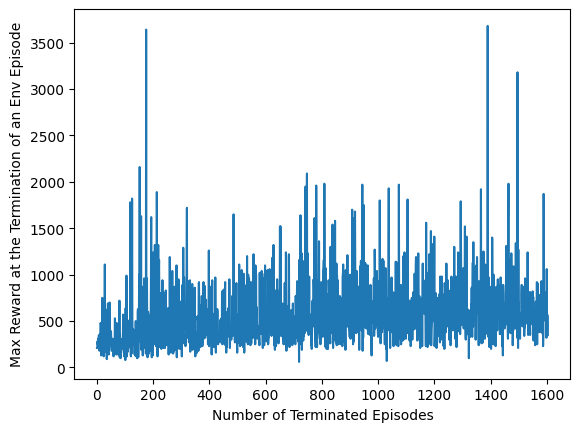

In [ ]:
if not len(agent.all_returns)%5==0:
    all_returns_truncated = np.array(agent.all_returns[:-(len(agent.all_returns)%5)])
else:
    all_returns_truncated = np.array(agent.all_returns)
#all_returns_smoothed = np.average(all_returns_truncated.reshape(-1, agent.num_episodes_to_avg), axis=1)
print('mean reward:', np.mean(all_returns_truncated))
print('std reward:', np.std(all_returns_truncated))
print('max reward:', np.max(all_returns_truncated))
print('converge mean reward:', np.mean(all_returns_truncated[-1]))
plt.xlabel('Number of Terminated Episodes')
plt.ylabel('Max Reward at the Termination of an Env Episode')
plt.plot(all_returns_truncated)
plt.show()

In [ ]:
test_env = make_env(env_name, seed)
#test_env = gym.wrappers.RecordVideo(test_env, f"videos/{env_name}test")
max_ep_steps = 5000
#observation, _ = test_env.reset()
terminated = False
truncated = False
steps = 0
total_reward = 0
observation, _ = test_env.reset()
observation = torch.unsqueeze(torch.tensor(observation, dtype=torch.float32),dim=0)

while not (terminated or truncated):
    # take action based on policy
    with torch.no_grad():
      action, _, _, _ = agent.agent.get_action_and_value(observation)
    action = action.cpu().item()

    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    observation, reward, terminated, truncated, info = test_env.step(action)
    observation = torch.unsqueeze(torch.tensor(observation, dtype=torch.float32),dim=0)
    #print(f'Reward: {reward}')
    total_reward += reward
    steps += 1

print(f'Reward: {total_reward}')

# store RGB frames for the entire episode
frames = test_env.render()

# close the environment
test_env.close()

# create and play video clip using the frames and given fps
clip = mpy.ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))

Reward: 730.0


In [ ]:
import os
res_dir = 'drive/MyDrive/Colab Notebooks/Reinforcement Learning/results'
res_path = os.path.join(os.getcwd(),res_dir)
res_path

'/content/drive/MyDrive/Colab Notebooks/Reinforcement Learning/results'

In [ ]:
agent.save(f"{res_path+'/mspacman.ram.128.ppo.pt'}")